Implement the code and run experiments for this paper:
WEAKLY SUPERVISED CLUSTERING BY EXPLOITING UNIQUE CLASS COUNT, Oner et al - https://openreview.net/forum?id=B1xIj3VYvr

Generate results for MNIST dataset for ucc and clustering as in Table 1 in the paper. Plot all your results for analysis and explain them.





Try:
1. Make different feature extractors and distribution regression
2. Use full MNIST data set 60,000 for training, also use subset of MNIST for
training and analyse the overfitting effects

I. 60,000 for training

II. 20,000 for training (same number of examples per class)

III. 5,000 for training (same number of examples per class)

IV. 500 for training (same number of examples per class)

 
3. Devise ways to improve this algorithm.




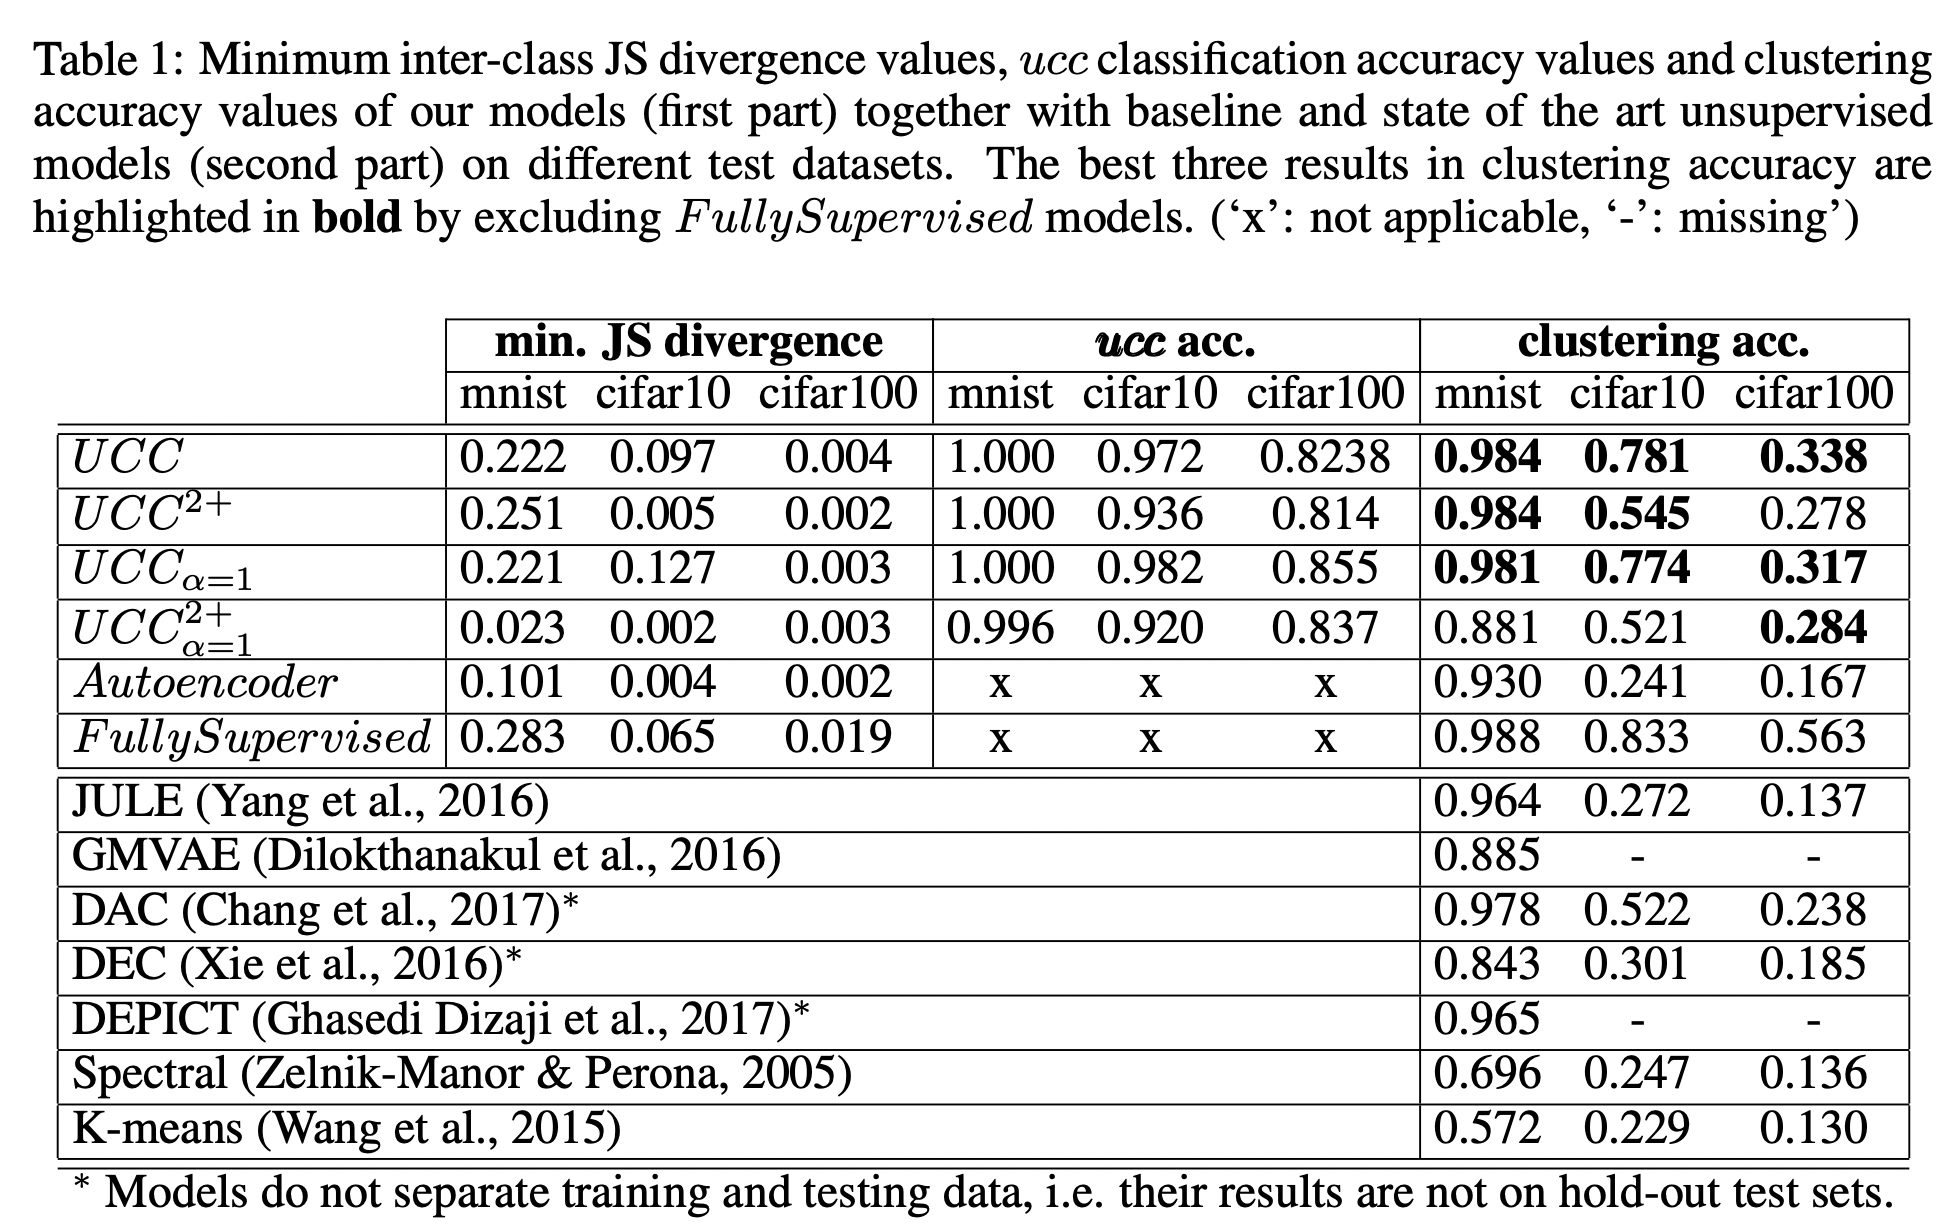

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/BS6207/Screenshot 2022-01-20 at 01.39.23.png', width = 600) 

In [ ]:
import numpy as np
import pydot
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import fnmatch
import os
import keras
from keras.datasets import mnist
from keras import backend as K
from itertools import combinations
from time import perf_counter

# Create datasets

In [ ]:
# From Orginal Paper
# AUTHORS: Mustafa Umit Oner, Hwee Kuan Lee & Wing-Kin Sung
# Modified by Sai Pandian, Mohammed Mosuily, Sameen Islam 

class Dataset(object):
	def __init__(self, num_instances=2, num_samples_per_class=16, digit_arr=None, ucc_start=1, ucc_end=10):
		
		self._num_instances = num_instances
		self._num_samples_per_class = num_samples_per_class
		self._digit_arr = digit_arr
		self._ucc_start = ucc_start
		self._ucc_end = ucc_end

		self._num_digits = len(self._digit_arr)

		self._num_classes = self._ucc_end - self._ucc_start + 1

		#splitted_dataset = np.load('../Datasets/splitted_mnist_dataset.npz')
		(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

		#x_train = splitted_dataset['x_train']
		#y_train = splitted_dataset['y_train']
		#x_val = splitted_dataset['x_val']
		#y_val = splitted_dataset['y_val']
		# x_test = splitted_dataset['x_test']
		# y_test = splitted_dataset['y_test']

		# del splitted_dataset

		x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
		x_train = x_train.astype('float32')
		x_train /= 255
		x_train = (x_train-np.mean(x_train,axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis])/np.std(x_train,axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
		print('x_train shape:', x_train.shape)
		print(x_train.shape[0], 'train samples')

		self._x_train = x_train
		self._y_train = y_train

		del x_train
		del y_train

		x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
		x_val = x_val.astype('float32')
		x_val /= 255
		x_val = (x_val-np.mean(x_val,axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis])/np.std(x_val,axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
		print(x_val.shape[0], 'val samples')
		
		self._x_val = x_val
		self._y_val = y_val

		del x_val
		del y_val

		self._digit_dict = self.get_digit_dict()
		self._class_dict_train = self.get_class_dict()
		self._class_dict_val = self.get_class_dict()

		self._labels = self.generate_labels()

	def get_digit_dict(self):
		digit_dict = dict()
		for i in range(self._num_digits):
			digit_key = 'digit' + str(i)
			digit_value = self._digit_arr[i]

			temp_digit_dict = dict()

			temp_digit_dict['value'] = digit_value
			temp_digit_dict['train_indices'] = np.where(self._y_train == digit_value)[0]
			temp_digit_dict['num_train'] = len(temp_digit_dict['train_indices'])
			temp_digit_dict['val_indices'] = np.where(self._y_val == digit_value)[0]
			temp_digit_dict['num_val'] = len(temp_digit_dict['val_indices'])

			print('{}:{}, num_train:{}, num_val:{}'.format(digit_key,digit_value,temp_digit_dict['num_train'],temp_digit_dict['num_val']))

			digit_dict[digit_key] = temp_digit_dict

		return digit_dict


	def get_class_dict(self):
		elements_arr = np.arange(self._num_digits)
		class_dict = dict()
		for i in range(self._num_classes):
			class_key = 'class_' + str(i)

			temp_class_dict = dict()
			# print(elements_arr)
			elements_list = list()
			for j in combinations(elements_arr,i+self._ucc_start):
				elements_list.append(np.array(j))

			elements_array = np.array(elements_list)
			np.random.shuffle(elements_array)
			temp_class_dict['tuples_arr'] = elements_array
			temp_class_dict['num_tuples'] = len(temp_class_dict['tuples_arr'])
			temp_class_dict['index'] = 0

			# print(temp_class_dict['tuples_arr'].shape)
			# print('{}, num_tuples:{}'.format(class_key,temp_class_dict['num_tuples']))

			class_dict[class_key] = temp_class_dict

		return class_dict

	def one_hot_label(self, label):
		one_hot_label = np.zeros(self._num_classes,dtype=np.int)
		one_hot_label[label]=1
		return one_hot_label

	def generate_labels(self):
		labels_list = list()
		for i in range(self._num_classes):
			labels_list.append(self.one_hot_label(i))

		labels_arr = np.repeat(np.array(labels_list),self._num_samples_per_class,axis=0)
		# print(labels_arr)

		return labels_arr

	def get_sample_data_train(self, indices_arr):
		sample = np.array(self._x_train[indices_arr,:,:,:])
		# print('Sample shape:{}'.format(sample.shape))
		return sample

	def next_batch_train(self):
		indices_list = list()
		for i in range(self._num_classes):
			class_key = 'class_' + str(i)
			# print('class_key:{}'.format(class_key))
			for j in range(self._num_samples_per_class):
				ind = self._class_dict_train[class_key]['index']
				temp_elements = self._class_dict_train[class_key]['tuples_arr'][ind,:]
				num_elements = temp_elements.shape[0]
				num_instances_per_element = self._num_instances // num_elements
				remainder_size = self._num_instances % num_elements
				num_instances_arr = np.repeat(num_instances_per_element,num_elements)
				num_instances_arr[:remainder_size] += 1

				for k in range(num_elements):
					digit_key = 'digit' + str(temp_elements[k])
					num_instances = num_instances_arr[k]
					indices_list += list(self._digit_dict[digit_key]['train_indices'][:num_instances])
					np.random.shuffle(self._digit_dict[digit_key]['train_indices'])

				self._class_dict_train[class_key]['index'] += 1

				if self._class_dict_train[class_key]['index'] >= self._class_dict_train[class_key]['num_tuples']:
					self._class_dict_train[class_key]['index'] = 0
					np.random.shuffle(self._class_dict_train[class_key]['tuples_arr'])
     
		indices_arr = np.array(indices_list)
		samples_arr = self.get_sample_data_train(indices_arr)
		samples_arr = np.reshape(samples_arr, (-1,self._num_instances,samples_arr.shape[1],samples_arr.shape[2],samples_arr.shape[3]))
		samples_data = np.transpose(samples_arr,(1,0,2,3,4))
		samples = list(samples_data)
		labels = self._labels
		return samples, [labels,samples_arr]

	def get_sample_data_val(self, indices_arr):
		sample = np.array(self._x_val[indices_arr,:,:,:])
		return sample

	def next_batch_val(self):
		indices_list = list()
		for i in range(self._num_classes):
			class_key = 'class_' + str(i)
			# print('class_key:{}'.format(class_key))
			for j in range(self._num_samples_per_class):
				ind = self._class_dict_val[class_key]['index']
				temp_elements = self._class_dict_val[class_key]['tuples_arr'][ind,:]
				num_elements = temp_elements.shape[0]
				num_instances_per_element = self._num_instances // num_elements
				remainder_size = self._num_instances % num_elements
				num_instances_arr = np.repeat(num_instances_per_element,num_elements)
				num_instances_arr[:remainder_size] += 1

				for k in range(num_elements):
					digit_key = 'digit' + str(temp_elements[k])
					num_instances = num_instances_arr[k]
					indices_list += list(self._digit_dict[digit_key]['val_indices'][:num_instances])
					np.random.shuffle(self._digit_dict[digit_key]['val_indices'])
     
				self._class_dict_val[class_key]['index'] += 1
				if self._class_dict_val[class_key]['index'] >= self._class_dict_val[class_key]['num_tuples']:
					self._class_dict_val[class_key]['index'] = 0
					np.random.shuffle(self._class_dict_val[class_key]['tuples_arr'])

		indices_arr = np.array(indices_list)
		samples_arr = self.get_sample_data_val(indices_arr)
		samples_arr = np.reshape(samples_arr, (-1,self._num_instances,samples_arr.shape[1],samples_arr.shape[2],samples_arr.shape[3]))
		samples_data = np.transpose(samples_arr,(1,0,2,3,4))
		samples = list(samples_data)
		labels = self._labels
		return samples, [labels,samples_arr]


# MNIST (full)

## Define the model


In [ ]:
# AUTHORS: Sai Pandian, Mohammed Mosuily, Sameen Islam 

from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from keras.layers.convolutional import Conv2D, UpSampling2D, ZeroPadding3D
from keras.layers.core import Activation, Dense, Reshape, Flatten
from keras.layers.merge import Add
from keras.models import Model
from keras.initializers import Constant, glorot_uniform
from keras import backend
import numpy as np

class Keras_Model(object):

    # defining models
    #---------------------------------------------------------------------------
    def __init__(self, patch_size=28, num_instances=2, num_classes=10, learning_rate=0.001, num_bins=None, num_features=10, batch_size=None):
        """UCC Model for MNIST data clustering"""

        # building the encoder
        #-----------------------------------------------------------------------
        image_input = Input((patch_size, patch_size, 1))
        x_enc = Conv2D(16, (3, 3), padding="same", bias_initializer=Constant(0.1), kernel_initializer=glorot_uniform(), kernel_regularizer=None)(image_input)
        x_enc = self.residual_layer(x_enc, 2, 1, 16, sample=False, reverse=False)
        x_enc = self.residual_layer(x_enc, 4, 1, 16, sample=True, reverse=False)
        x_enc = self.residual_layer(x_enc, 8, 1, 16, sample=True, reverse=False)
        x_enc = Activation("relu")(x_enc)
        x_enc = Flatten()(x_enc)
        encoded_output = Dense(num_features, activation="sigmoid", use_bias=False, kernel_initializer=glorot_uniform(), kernel_regularizer=None)(x_enc)
        self._patch_model = Model(inputs=image_input, outputs=encoded_output)


        # building the decoder
        #-----------------------------------------------------------------------
        encoded_input = Input((num_features,))
        x_dec = Dense(6272, bias_initializer=Constant(0.1), kernel_initializer=glorot_uniform(), kernel_regularizer=None)(encoded_input)
        x_dec = Reshape((7, 7, 128))(x_dec)
        x_dec = self.residual_layer(x_dec, 8, 1, 16, sample=True, reverse=True)
        x_dec = self.residual_layer(x_dec, 4, 1, 16, sample=True, reverse=True)
        x_dec = self.residual_layer(x_dec, 2, 1, 16, sample=False, reverse=True)
        x_dec = Activation("relu")(x_dec)
        decoded_output = Conv2D(1, (3, 3), padding="same", bias_initializer=Constant(0.1), kernel_initializer=glorot_uniform(), kernel_regularizer=None)(x_dec)
        self._image_generation_model = Model(inputs=encoded_input, outputs=decoded_output)


        # build total autoencoder model
        #-----------------------------------------------------------------------
        autoencoded_output = self._image_generation_model(encoded_output)
        self._autoencoder_model = Model(inputs=image_input, outputs=autoencoded_output)


        # running the encoder/autoencoder models to get out img and feature list
        #-----------------------------------------------------------------------
        original_input_list = []
        encoded_output_list = []
        autoencoded_output_list = []
        for i in range(num_instances):
            # get input
            input_tmp = Input((patch_size, patch_size, 1))
            original_input_list.append(input_tmp) # add input image to list

            # Run encoder model
            output_tmp = self._patch_model(input_tmp)
            output_tmp = Reshape((1, -1))(output_tmp)
            encoded_output_list.append(output_tmp) # add encoded image to list

            # Run autoencoder model
            autoencoded_output_tmp = self._autoencoder_model(input_tmp)
            autoencoded_output_tmp = Reshape((1, patch_size, patch_size, 1))(autoencoded_output_tmp)
            autoencoded_output_list.append(autoencoded_output_tmp) # add autoencoded image to list


        # build kernel density estimation model
        #-----------------------------------------------------------------------
        concatenated_encoded = layers.concatenate(encoded_output_list, axis=1)
        concatenated_autoencoded = layers.concatenate(autoencoded_output_list, axis=1)
        x_kde = layers.Lambda(self.kernel_density_estimation, arguments={"num_bins":num_bins, "sigma":0.1, "batch_size":batch_size, "num_features":num_features})(concatenated_encoded)
        self._distribution_model = Model(inputs=original_input_list, outputs=x_kde)


        # build classification model
        #-----------------------------------------------------------------------

        x_class = Dense(384, activation="relu", kernel_initializer=glorot_uniform(), kernel_regularizer=None)(x_kde)
        x_class = Dense(192, activation="relu", kernel_initializer=glorot_uniform(), kernel_regularizer=None)(x_class)
        class_output = Dense(num_classes, activation="softmax", kernel_initializer=glorot_uniform(), kernel_regularizer=None)(x_class)
        self._classification_model = Model(inputs=original_input_list, outputs=[class_output, concatenated_autoencoded])


        # define some more models (might be able to delete some of these)
        #-----------------------------------------------------------------------
        self._features_model = Model(inputs=original_input_list, outputs=concatenated_encoded)
        self._ucc_model = Model(inputs=original_input_list, outputs=class_output)


        # set optimiser and loss function
        #-----------------------------------------------------------------------
        optimiser = Adam(learning_rate = learning_rate)
        self._classification_model.compile(optimizer=optimiser, 
                                           validation_data=(split_dataset._x_val, split_dataset._y_val),
                                           loss=["categorical_crossentropy", "mse"], 
                                           metrics=["accuracy"], 
                                           loss_weights=[0.5, 0.5])

    
    # defining kde function for kde layer
    # --------------------------------------------------------------------------
    def kernel_density_estimation(self, features, num_bins=None, sigma=None, batch_size=None, num_features=None):
        """kernel density esimation function used in the kde layer
        
        For some reason, this function does not work if we use some numpy functions
        like np.sum, or Keras layers like Flatten and Reshape. So instead we
        have to get these from keras.backends. I have tried to fix this, but I
        cannot, so leaving in for a future person to solve! """

        x = np.linspace(0, 1, num_bins)
        sample_points = backend.constant(np.tile(x, [batch_size, backend.int_shape(features)[1], 1]))

        a = backend.constant((np.sqrt(2 * np.pi * sigma**2)**-1))
        b = backend.constant((-2 * sigma**2)**-1)

        output_list = []
        for i in range(num_features):
            tmp = backend.reshape(features[:,:,i], (-1, backend.int_shape(features)[1], 1))
            diff = (sample_points - backend.tile(tmp, [1, 1, num_bins]))**2
            result = a * backend.exp(b * diff)

            output = backend.sum(result, axis=1)

            normalisaton_coefficient = backend.reshape(backend.sum(output, axis=1), (-1,1))

            output_normed = output / backend.tile(normalisaton_coefficient, [1, backend.int_shape(output)[1]])
            output_list.append(output_normed)

        concatenated_output = backend.concatenate(output_list, axis=-1)
        return concatenated_output


    # defining residual layer used in autoencoding model
    # --------------------------------------------------------------------------
    def residual_layer(self, x, filters, n, channels, sample=False, reverse=False):
        """residual layer definition
        
        if the reverse parameter is set to True, it executes the reverse"""

        for i in range(n):
            if i == 0:
                x = self.residual_block(x, filters * channels, first=True, sample=sample, reverse=reverse)
            else:
                x = self.residual_block(x, filters * channels, first=False, sample=sample, reverse=reverse)
        return x

    # defining residual block defined in residual layer
    # --------------------------------------------------------------------------
    def residual_block(self, x0, filters, first=False, sample=False, reverse=False):
        
        kwargs_1 = {"kernel_size": (3, 3),
                    "padding": "same",
                    "bias_initializer": Constant(value=0.1),
                    "use_bias": True,
                    "kernel_initializer": glorot_uniform(),
                    "kernel_regularizer": None
	}
        kwargs_2 = {"kernel_size": (1, 1),
                    "padding": "valid",
                    "use_bias": True,
                    "kernel_initializer": glorot_uniform(),
                    "kernel_regularizer": None}

        if first:
            if reverse == False:
                    # set appropriate strides to reduce size (downsample)
                    if sample == True:
                        kwargs_1["strides"] = (2, 2)
                        kwargs_2["strides"] = (2, 2)

                    x0 = Activation("relu")(x0)

                    x1 = Conv2D(filters, **kwargs_1)(x0)
                    x1 = Activation("relu")(x1)

                    # reset the stride length
                    kwargs_1["strides"] = (1, 1)

                    x1 = Conv2D(filters, **kwargs_1)(x1)

                    x0_shape = x0.shape.as_list()[1:-1]
                    x1_shape = x1.shape.as_list()[1:-1]
                    x0_filter = x0.shape.as_list()[-1]
                    x1_filter = x1.shape.as_list()[-1]

                    if x0_shape != x1_shape:
                            x0 = Conv2D(x0_filter, **kwargs_2)(x0)

                    if x0_filter != x1_filter:
                            t_shape = (x1_shape[0], x1_shape[1], x0_filter, 1)
                            x0 = Reshape(t_shape)(x0)
                            padding_size = x1_filter - x0_filter
                            x0 = ZeroPadding3D(((0, 0), (0, 0), (0, padding_size)))(x0)
                            t_shape = (x1_shape[0], x1_shape[1], x1_filter)
                            x0 = Reshape(t_shape)(x0)

            elif reverse == True:
                x0 = Activation("relu")(x0)

                # do appropriate step to increase size (upsampling)
                if sample == True:
                    x0 = UpSampling2D((2, 2))(x0)

                x1 = Conv2D(filters, **kwargs_1)(x0)
                x1 = Activation("relu")(x1)
                x1 = Conv2D(filters, **kwargs_1)(x1)

                if x0.shape.as_list()[-1] != x1.shape.as_list()[-1]:
                    x0 = Conv2D(filters, **kwargs_2)(x0)

        else:
            x1 = Activation("relu")(x0)
            x1 = Conv2D(filters, **kwargs_1)(x1)
            x1 = Activation("relu")(x1)
            x1 = Conv2D(filters, **kwargs_1)(x1)

        x0 = Add()([x0, x1])
        return x0


    # functions to train and test model (Taken from original code)
    # --------------------------------------------------------------------------

    def train_on_batch_data(self, batch_inputs=None, batch_outputs=None):
        stats = self._classification_model.train_on_batch(batch_inputs, batch_outputs)
        
        return stats

    def test_on_batch_data(self, batch_inputs=None, batch_outputs=None):
        stats = self._classification_model.test_on_batch(batch_inputs, batch_outputs)
        return stats

    def predict_on_batch_data(self, batch_inputs=None):
        predicted_label = self._classification_model.predict_on_batch(batch_inputs)
        
        return predicted_label

    def predict_ucc_on_batch_data(self, batch_inputs=None):
        predicted_label = self._ucc_model.predict_on_batch(batch_inputs)
        return predicted_label

    def predict_on_batch_data_ae(self, batch_inputs=None):
        predicted_label = self._autoencoder_model.predict_on_batch(batch_inputs)
        return predicted_label

    def generate_image_from_feature(self, batch_inputs=None):
        predicted_label = self._image_generation_model.predict_on_batch(batch_inputs)
        
        return predicted_label

    def predict_on_batch_data_distribution(self, batch_inputs=None):
        predicted_dist = self._distribution_model.predict_on_batch(batch_inputs)
        return predicted_dist

    def predict_on_batch_data_features(self, batch_inputs=None):
        predicted_features = self._features_model.predict_on_batch(batch_inputs)
    
        return predicted_features

    def predict_on_batch_data_patches(self, batch_inputs=None):
        predicted_patches = self._patch_model.predict_on_batch(batch_inputs)
        
        return predicted_patches

    def save_model_weights(self, model_weight_save_path=None):
        self._classification_model.save_weights(model_weight_save_path)
        self._autoencoder_model.save_weights(model_weight_save_path[:-3]+'__ae.h5')
        
    def load_saved_weights(self, weights_path=None):
        self._classification_model.load_weights(weights_path)
        self._autoencoder_model.load_weights(weights_path[:-3]+'__ae.h5')

    @property
    def metrics_names(self):
        return self._classification_model.metrics_names
    
    @property
    def yaml_file(self):
        return self._classification_model.to_yaml()

In [ ]:
# define model
# the min/max number of possible classes
min_classes = 1
max_classes = 4

#from dataset import Dataset
#from model import Keras_Model

# number of epochs:
n_epochs = 10000

# number of instances
num_instances = 32

# subsets in MNIST data
subsets_elements_arr = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# get initial approx num classes and num samples per class
num_classes =  max_classes - min_classes + 1
num_samples_per_class = int(20 / num_classes)

# get batch size
batch_size = num_classes * num_samples_per_class

# define dataset
split_dataset = Dataset(num_instances=num_instances, 
                        num_samples_per_class=num_samples_per_class,
                        digit_arr=subsets_elements_arr, 
                        ucc_start=min_classes, 
                        ucc_end=max_classes)


x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 val samples
digit0:0, num_train:5923, num_val:980
digit1:1, num_train:6742, num_val:1135
digit2:2, num_train:5958, num_val:1032
digit3:3, num_train:6131, num_val:1010
digit4:4, num_train:5842, num_val:982
digit5:5, num_train:5421, num_val:892
digit6:6, num_train:5918, num_val:958
digit7:7, num_train:6265, num_val:1028
digit8:8, num_train:5851, num_val:974
digit9:9, num_train:5949, num_val:1009


In [ ]:
!git clone https://github.com/COMP6248-Reproducability-Challenge/UCC-Classifier.git
model = Keras_Model(patch_size=28, 
                    num_instances=32, 
                    num_classes=num_classes, 
                    learning_rate=1e-4, 
                    num_bins=11, 
                    num_features=10, 
                    batch_size=batch_size)

#model._classification_model.load_weights("/content/UCC-Classifier/MNIST_Model/saved_models/2020_04_05__20_31_24_128000/MNIST_classifier_weights_2000.h5")
#model._autoencoder_model.load_weights("/content/UCC-Classifier/MNIST_Model/saved_models/2020_04_05__20_31_24_128000/MNIST_autoenc_weights_2000.h5")

fatal: destination path 'UCC-Classifier' already exists and is not an empty directory.


## Model training

In [ ]:
# AUTHORS: Sai Pandian, Mohammed Mosuily, Sameen Islam 

import numpy as np
import pandas as pd

# number of epochs:
n_epochs = 10000

# train
ae_train_loss = []
ucc_train_loss = []
total_train_loss = []
ae_test_loss = []
ucc_test_loss = []
total_test_loss = []
timer_count = []

In [ ]:
for i in range(n_epochs):
    start_time = perf_counter()
    print("Epoch:", str(i+1)+"/"+str(n_epochs))
    print("Getting Next Batch...")
    train_batch = split_dataset.next_batch_train()

    print("Training on Batch...")
    [train_loss_weighted, train_ucc_loss, train_ae_loss, train_ucc_acc, train_ae_acc] = model.train_on_batch_data(train_batch[0], train_batch[1])
    ae_train_loss.append(train_ae_loss)
    ucc_train_loss.append(train_ucc_loss)
    total_train_loss.append(train_loss_weighted)
    duration = perf_counter() - start_time
    timer_count.append(duration)
    
    # do validation every 100th epoch
    if i % 100 == 0:
        print()
        print("Getting Validation Batch...")
        validation_batch = split_dataset.next_batch_val()
        print("Testing on Batch...")
        [val_loss_weighted, val_ucc_loss, val_ae_loss, val_ucc_acc, val_ae_acc] = model.test_on_batch_data(validation_batch[0], validation_batch[1])
        ae_test_loss.append(val_ae_loss)
        ucc_test_loss.append(val_ucc_loss)
        total_test_loss.append(val_loss_weighted)

        print("Saving Model...")
        model._classification_model.save("/content/drive/MyDrive/BS6207/MNIST_classifier_weights_60000_epoch{}.h5".format(i))
        model._autoencoder_model.save("/content/drive/MyDrive/BS6207/MNIST_autoenc_weights_60000_epoch{}.h5".format(i))
        print("Model Saved!")
        
    print()
    print("Subset:                   ", subsets_elements_arr)
    print("Train Loss Weighted:      ", train_loss_weighted)
    print("Train UCC Accuracy:       ", train_ucc_acc)
    print("Train UCC Loss:           ", train_ucc_loss)
    print("Train AE Loss:            ", train_ae_loss)
    print("Train time per epoch:     ", '{} s'.format(duration))
    print("................................................................")

Epoch: 1/10000
Getting Next Batch...
Training on Batch...

Getting Validation Batch...
Testing on Batch...
Saving Model...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Streaming output truncated to the last 5000 lines.

Subset:                    [0 1 2 3 4 5 6 7 8 9]
Train Loss Weighted:       0.3882320523262024
Train UCC Accuracy:        0.8500000238418579
Train UCC Loss:            0.5116522908210754
Train AE Loss:             0.26481181383132935
Train time per epoch:      40.97931871000037 s
................................................................
Epoch: 1735/10000
Getting Next Batch...
Training on Batch...

Subset:                    [0 1 2 3 4 5 6 7 8 9]
Train Loss Weighted:       0.42936867475509644
Train UCC Accuracy:        0.6499999761581421
Train UCC Loss:            0.5951326489448547
Train AE Loss:             0.26360467076301575
Train time per epoch:      27.387092543998733 s
................................................................
Epoch: 1736/10000
Getting Next Batch...
Training on Batch...

Subset:                    [0 1 2 3 4 5 6 7 8 9]
Train Loss Weighted:       0.4165439009666443
Train UCC Accuracy:        0.850000

KeyboardInterrupt: ignored

In [ ]:
print("Training Finished!")

print("Saving Loss Values...")
data = {
    "ae_train_loss": ae_train_loss,
    "ucc_train_loss": ucc_train_loss,
    "total_train_loss": total_train_loss,
    "ae_train_loss": ae_test_loss,
    "ucc_train_loss": ucc_test_loss,
    "total_train_loss": total_test_loss
}
df = pd.DataFrame(data)
df.to_csv("/content/drive/MyDrive/losses_60000.csv", index=False)

print("Saving Loss Values...")
data = {
    "ae_test_loss": ae_test_loss,
    "ucc_test_loss": ucc_test_loss,
    "total_test_loss": total_test_loss
}
df = pd.DataFrame(data)
df.to_csv("/content/drive/MyDrive/losses_val_60000.csv", index=False)

Training Finished!
Saving Loss Values...
Saving Loss Values...


In [ ]:
len(total_test_loss)

22